<a href="https://colab.research.google.com/github/peruvianox/Vetta/blob/main/MagVect_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.4 MB/s 
     |████████████████████████████████| 9.9 MB 38.5 MB/s 
  Created wheel for pingouin: filename=pingouin-0.5.2-py3-none-any.whl size=196208 sha256=b244ad9bb8f94daa0a82ea49a447bc76462f752cf34aa6356af42afdcfbc268f
  Stored in directory: /root/.cache/pip/wheels/75/b0/89/f6866fc5accea9bec04f4c9f2a242520d6e8e7b8fcf89e139c
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7047 sha256=b6f450e0979d39005f3644717d66a53ad229949e282c1e2f8c8e6b8e340cd10f
  Stored in directory: /root/.cache/pip/wheels/6a/33/c4/0ef84d7f5568c2823e3d63a6e08988852fb9e4bc822034870a
Successfully built pingouin littleutils
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 3.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pingouin 0.5.2 requires scikit-learn<1.1.0, but you have scikit-learn 1.2.0 which is incompatible.


In [3]:
import sklearn
print('sklearn version =', sklearn.__version__)

sklearn version = 1.2.0


In [4]:
from google.colab import drive
drive.mount("/content/drive")
import os
import re
import pandas as pd
import datetime as dt
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import signal
from scipy import interpolate
from google.colab import output
from sklearn import linear_model
from sklearn import metrics
import time 
from sklearn import svm
from sklearn.neural_network import MLPRegressor
import sqlite3
import pingouin as pg
DataFolder = '/content/drive/My Drive/EII-PGB/Data/SyncedData'
os.chdir(DataFolder)

plt.rcParams.update({'font.size': 15})

Mounted at /content/drive


# Load Subject Data

In [5]:
ReProcess = 0

if ReProcess == 0:
  Data = pd.read_csv('FullData.csv').reset_index(drop=True)
  Cols = Data.columns
  Cols2Del = []
  for i, c in enumerate(Cols): # identify unnamed columns
    if 'Unnamed' in c: 
      Cols2Del.append(c)
  Data = Data.drop(columns=Cols2Del) # get rid of unnamed column

  Meta = pd.read_csv('MetaData.csv').reset_index(drop=True)

elif ReProcess == 1: # REPROCESS DATA

  # make column names for dataframe
  grf = []
  Fc = []
  Sc = []
  Wc = []
  Cc = []
  for i in range(100):
    grf.append('GRF' + str(i))
    Fc.append('Foot' + str(i))
    Sc.append('Shank' + str(i))
    Wc.append('Waist' + str(i))
    Cc.append('Torso' + str(i))

  Cols = np.hstack([grf, Fc, Sc, Wc, Cc]) # join column lists together

  # get list of table names
  con = sqlite3.connect('steps.db')

  def sql_fetch(con):
    cur = con.cursor()
    cur.execute('SELECT name FROM sqlite_master WHERE type="table"')
    return list(cur.fetchall())

  TableNames = sql_fetch(con)

  # loop through all table names and extract steps
  con = sqlite3.connect('steps.db')
  Meta = pd.DataFrame(columns=['Subj', 'Cond', 'Side', 'Step'])
  Data = pd.DataFrame(columns=Cols)
  df = {}
  for T in TableNames:
    t = T[0]
    i = int(t.split("_")[0][1:]) - 1
    cur = con.cursor()
    CuteStr = 'SELECT * FROM ' + t
    cur.execute(CuteStr)
    result_data = cur.fetchall()
    cols = [description[0] for description in cur.description]
    d = pd.DataFrame(result_data, columns=cols)

    # perform vector magnidute combinations for each accelerometer
    if '_L' in t: 
      Foot = np.sqrt(d['LF_X']**2 + d['LF_Y']**2 + d['LF_Z']**2)  
      Shank = np.sqrt(d['LS_X']**2 + d['LS_Y']**2 + d['LS_Z']**2)  
      vGRF = d['GRF_Ly']
    elif '_R' in t: 
      Foot = np.sqrt(d['RF_X']**2 + d['RF_Y']**2 + d['RF_Z']**2)  
      Shank = np.sqrt(d['RS_X']**2 + d['RS_Y']**2 + d['RS_Z']**2)  
      vGRF = d['GRF_Ry'] 
        
    Waist = np.sqrt(d['SAC_X']**2 + d['SAC_Y']**2 + d['SAC_Z']**2)  
    Torso = np.sqrt(d['TOR_X']**2 + d['TOR_Y']**2 + d['TOR_Z']**2)     
    
    Data.loc[len(Data) + 1] = np.hstack([vGRF, np.array(Foot), np.array(Shank), 
                np.array(Waist), np.array(Torso)])
    
    Fname = t.split('_')
    Meta.loc[len(Meta) + 1] = [Fname[0], Fname[1], Fname[2][0], Fname[2][1]]
    # print('Saving Step: ' + t)

  con.close()

  Data.to_csv('FullData.csv')
  Meta.to_csv('MetaData.csv')
  print('All Data Loaded')

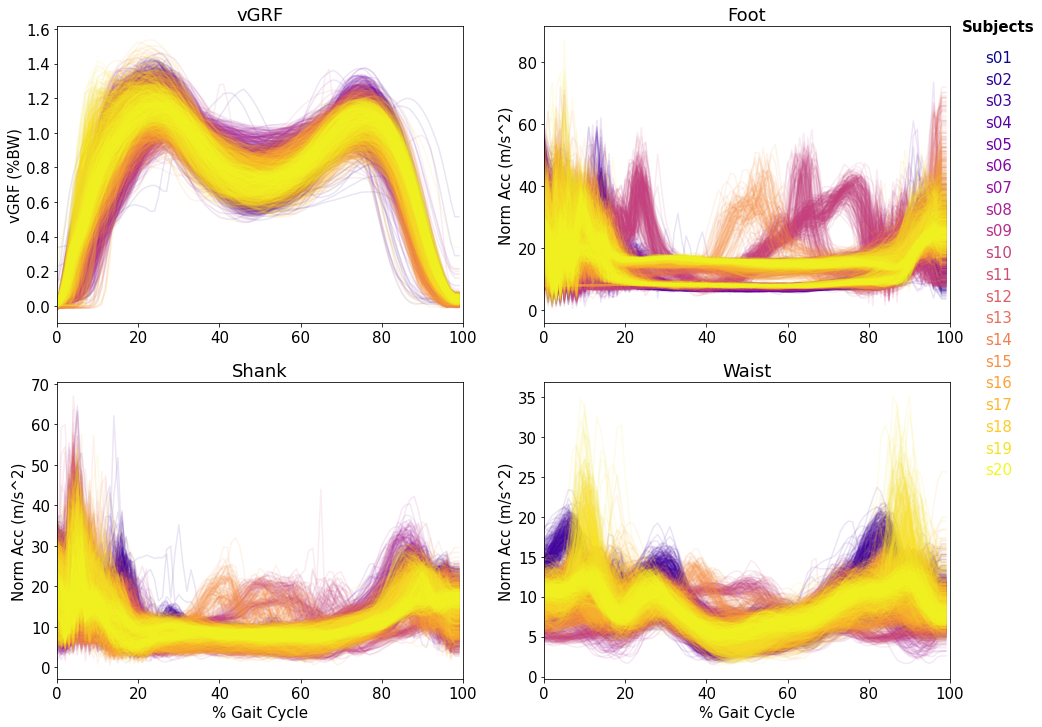

In [6]:
# plot acceleration data
Cols = Data.columns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
C = cm.get_cmap('plasma', 20)

Foot = Data[[x for x in Data.columns if 'Foot' in x]].to_numpy().T
Shank = Data[[x for x in Data.columns if 'Shank' in x]].to_numpy().T
Waist = Data[[x for x in Data.columns if 'Waist' in x]].to_numpy().T
vGRF = Data[[x for x in Data.columns if 'GRF' in x]].to_numpy().T

plt.figure(figsize=(16,12))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
A = 0.1

for r in range(len(Data)):

  i = int(Meta.Subj[r][1:])
  # plot all Acceleration signals
  ax1.plot(vGRF[:,r],'-k', c=C.colors[i-1], alpha=A)
  ax2.plot(Foot[:,r],'-k', c=C.colors[i-1], alpha=A)
  ax3.plot(Shank[:,r],'-k', c=C.colors[i-1], alpha=A)
  ax4.plot(Waist[:,r],'-k', c=C.colors[i-1], alpha=A)

# edit axes
ax1.set_title('vGRF')
ax1.set_xlim([0, 100])
ax1.set_ylabel('vGRF (%BW)')
ax2.set_title('Foot')
ax2.set_xlim([0, 100])
ax2.set_ylabel('Norm Acc (m/s^2)')
ax3.set_title('Shank')
ax3.set_xlim([0, 100])
ax3.set_ylabel('Norm Acc (m/s^2)')
ax3.set_xlabel('% Gait Cycle')
ax4.set_title('Waist')
ax4.set_xlim([0, 100])
ax4.set_ylabel('Norm Acc (m/s^2)')
ax4.set_xlabel('% Gait Cycle')

Subjs = np.unique(Meta.Subj)
ax2.text(112, 90, 'Subjects', c='k', ha='center', weight='bold')
for i in range(20):
  ax2.text(112, 80 - 7*i, Subjs[i], c=C.colors[i], ha='center')

plt.savefig('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder/Inputs.png')

# Define functions for processing

In [7]:
# define functions for processing later on
def ccc(x,y):
    ''' Concordance Correlation Coefficient'''
    x = np.array(x)
    y = np.array(y)
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

def GetInds(Cols: list, Terms: list):
  # get indicies of terms in a list
  Inds = []
  for i, c in enumerate(Cols): 
    for q in Terms: 
      if re.match(q, c):
        Inds.append(i-1)

  return Inds

from matplotlib import cm
cmap = cm.rainbow(np.linspace(0, 1, 20))
plt.style = 'seaborn'

# Predict full waveform

MLP Neural Network

In [8]:
MLP = {}
plt.figure(figsize=(10,10))
models = ['FSW', 'FW', 'SW', 'FS', 'S', 'F', 'W']
AggMLP = {}


for model in models:
    plt.clf()
    if model == 'Full':
        Inputs = GetInds(Cols, ['Foot','Shank','Thigh','Waist','Torso'])
    elif model == 'FSW':
        Inputs = GetInds(Cols, ['Foot','Shank','Waist'])
    elif model == 'FW':
        Inputs = GetInds(Cols, ['Foot','Waist'])
    elif model == 'SW':
        Inputs = GetInds(Cols, ['Shank','Waist'])
    elif model == 'FS':
        Inputs = GetInds(Cols, ['Foot','Shank'])
    elif model == 'S':
        Inputs = GetInds(Cols, ['Shank'])
    elif model == 'F':
        Inputs = GetInds(Cols, ['Foot'])
    elif model == 'W':
        Inputs = GetInds(Cols, ['Waist'])

    
    AggMLP[model] = {}

    # implement K-fold cross validation for splitting testing & training inputs
    from sklearn.model_selection import KFold
    X = Data.iloc[:,100:]
    y = Data.iloc[:,0:99]
    S = np.unique(Meta['Subj'])

    # split based on subject indexes
    kf = KFold(n_splits=5)
    k = 0

    
    for TrainSubj, TestSubj in kf.split(S):
      print('Iteration: ' + str(k))
      print('Training on: ', S[TrainSubj])
      print('Testing on: ', S[TestSubj])

      TrainInds = [i for i, x in enumerate(Meta['Subj']) if x in S[TrainSubj]]
      TestInds = [i for i, x in enumerate(Meta['Subj']) if x in S[TestSubj]]

      # specify testing & training sets
      X_train = Data.iloc[TrainInds, Inputs]
      Y_train = Data.iloc[TrainInds,0:99]
      X_test = Data.iloc[TestInds, Inputs]
      Y_test = Data.iloc[TestInds,0:99]

      Meta_train = Meta.iloc[TrainInds]
      Meta_test = Meta.iloc[TestInds]

      # MLP
      MLP[model] = {}
      # clf = MLPRegressor(random_state=1, max_iter=500, verbose=False, activation='logistic')
      clf = MLPRegressor(random_state=1, max_iter=500, verbose=False, activation='logistic', hidden_layer_sizes=200)
      start = time.time()
      clf.fit(X_train,Y_train) # Fit model
      MLP_P = clf.predict(X_test) # predict
      finish = time.time()
      MLP[model]['Model'] = clf

      # save outputs
      MLP[model]['Training Time'] = finish-start
      MLP[model]['RMSE'] = np.sqrt(metrics.mean_absolute_error(Y_test, MLP_P))
      MLP[model]['MAE'] = metrics.mean_absolute_error(Y_test, MLP_P)
      MLP[model]['R^2'] = metrics.r2_score(Y_test, MLP_P)
      MLP[model]['CCC'] = round(ccc(Y_test, MLP_P), 4)
      MLP[model]['Prediction'] = MLP_P
      MLP[model]['True'] = np.array(Y_test)
      MLP[model]['Test Metadata'] = Meta_test
      MLP[model]['Train Metadata'] = Meta_train
      MLP[model]['Test Input'] = np.array(X_test)

      # print results
      print('MLP Model: ' + model)
      print('RMS Error = ' +     str(MLP[model]['RMSE']))
      print('MAE = ' +           str(MLP[model]['MAE']))
      print('')

      # save model accuracy for each iteration & model
      AggMLP[model][k] = MLP[model]
      k += 1

Iteration: 0
Training on:  ['s05' 's06' 's07' 's08' 's09' 's10' 's11' 's12' 's13' 's14' 's15' 's16'
 's17' 's18' 's19' 's20']
Testing on:  ['s01' 's02' 's03' 's04']
MLP Model: FSW
RMS Error = 0.26981241056076666
MAE = 0.07279873689261171

Iteration: 1
Training on:  ['s01' 's02' 's03' 's04' 's09' 's10' 's11' 's12' 's13' 's14' 's15' 's16'
 's17' 's18' 's19' 's20']
Testing on:  ['s05' 's06' 's07' 's08']
MLP Model: FSW
RMS Error = 0.2813248750338382
MAE = 0.07914368531280466

Iteration: 2
Training on:  ['s01' 's02' 's03' 's04' 's05' 's06' 's07' 's08' 's13' 's14' 's15' 's16'
 's17' 's18' 's19' 's20']
Testing on:  ['s09' 's10' 's11' 's12']
MLP Model: FSW
RMS Error = 0.2680421087098865
MAE = 0.07184657204164259

Iteration: 3
Training on:  ['s01' 's02' 's03' 's04' 's05' 's06' 's07' 's08' 's09' 's10' 's11' 's12'
 's17' 's18' 's19' 's20']
Testing on:  ['s13' 's14' 's15' 's16']
MLP Model: FSW
RMS Error = 0.2732319400968868
MAE = 0.07465569308910872

Iteration: 4
Training on:  ['s01' 's02' 's03' '

<Figure size 720x720 with 0 Axes>

# Plot Results

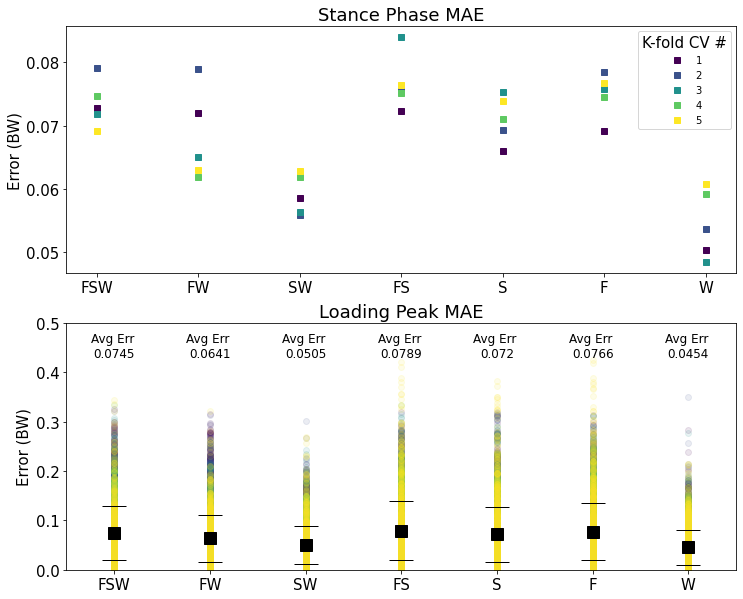

In [16]:
os.chdir('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder')

plt.figure(figsize=(12, 10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

# plot whole stance MAE
C = cm.get_cmap('viridis', 5)

for Ind, model in enumerate(models):
  for i, x in enumerate(AggMLP[model]):

    if Ind == 0:
      ax1.plot(Ind, AggMLP[model][i]['MAE'], 's', c=C.colors[i], label=i+1)
    else:
      ax1.plot(Ind, AggMLP[model][i]['MAE'], 's', c=C.colors[i])

ax1.legend(fontsize=10, title='K-fold CV #')
ax1.set_xticks(range(len(models)))
ax1.set_yticks([0.05, 0.06, 0.07, 0.08])
ax1.set_xticklabels(models)
ax1.set_ylabel('Error (BW)')
ax1.set_title('Stance Phase MAE')


# get loading peak error
AvgError = {}
StdError = {}
for Ind, model in enumerate(models):
  AvgError[model] = []
  StdError[model] = []
  for i, x in enumerate(AggMLP[model]):
    AggMLP[model][i]['TruePk'] = np.zeros((len(AggMLP[model][i]['True']),1))
    AggMLP[model][i]['PredPk'] = np.zeros((len(AggMLP[model][i]['Prediction']),1))
    AggMLP[model][i]['PkErr'] = np.zeros((len(AggMLP[model][i]['Prediction']),1))

    
    for r in range(len(AggMLP[model][i]['Prediction'])):
      AggMLP[model][i]['TruePk'][r] = np.max(AggMLP[model][i]['True'][r, 0:50])
      AggMLP[model][i]['PredPk'][r] = np.max(AggMLP[model][i]['Prediction'][r, 0:50])
      AggMLP[model][i]['PkErr'][r] = abs(AggMLP[model][i]['TruePk'][r] - AggMLP[model][i]['PredPk'][r])

      plt.plot(Ind, AggMLP[model][i]['PkErr'][r], 'o', c=C.colors[i], alpha=A)
  
    AvgError[model].append(np.mean(AggMLP[model][i]['PkErr']))
    StdError[model].append(np.std(AggMLP[model][i]['PkErr']))

  # plot average error
  ax2.errorbar(Ind, np.mean(AvgError[model]), np.mean(StdError[model]), ms=10,
               fmt='sk', ecolor='k', elinewidth=4, capsize=12)

  ax2.text(Ind, 0.43, 'Avg Err \n' + str(round(np.mean(AvgError[model]),4)), ha='center', fontsize=12)

ax2.set_xticks(range(len(models)))
ax2.set_xticklabels(models)
ax2.set_ylabel('Error (BW)')
ax2.set_title('Loading Peak MAE')
ax2.set_xlim([-0.5, 6.5])
ax2.set_ylim([0, 0.5])

plt.savefig('MAE.png')

FSW
FW
SW
FS
S
F
W


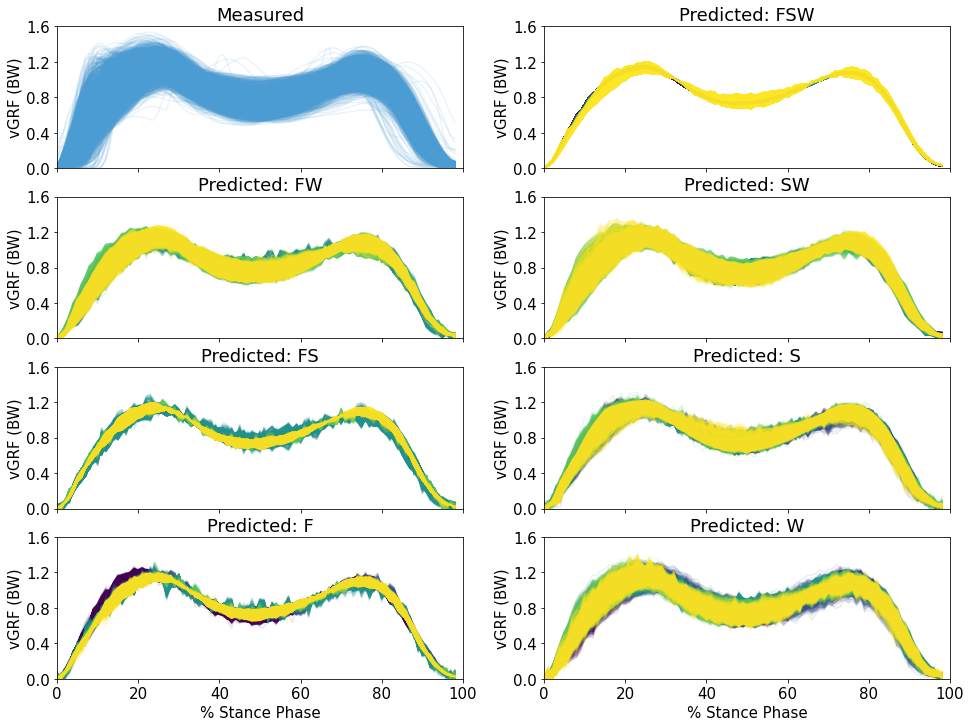

In [18]:
# plot all raw predicitons
os.chdir('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder')

A = 0.1
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
C = cm.get_cmap('viridis', 5)

# plot true
plt.figure(figsize=(16, 12))
ax1 = plt.subplot(4, 2, 1)
plt.title('Measured')
for i, x in enumerate(AggMLP[model]):
  plt.plot(AggMLP[model][i]['True'][:, :].T, '-k', alpha=A, c=(75/255, 156/255, 211/255)) 
plt.ylabel('vGRF (BW)')
# plt.xlabel('% Stance Phase')
plt.ylim((0, 1.6))
plt.yticks([0, 0.4, 0.8, 1.2, 1.6])
plt.xlim((0, 100))
plt.xticks([0, 20, 40, 60, 80, 100], labels = [])


for j, model in enumerate(models):
  ax = plt.subplot(4, 2, j + 2)
  print(model)
  for i, x in enumerate(AggMLP[model]):
    ax.plot(AggMLP[model][i]['Prediction'].T, '-k', alpha=A,  c = C.colors[i,:]) #c=(75/255, 156/255, 211/255))

  ax.set_title('Predicted: ' + model)
  ax.set_ylabel('vGRF (BW)')
  
  ax.set_ylim((0, 1.6))
  ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6])
  ax.set_xlim((0, 100))
  ax.set_xticks([0, 20, 40, 60, 80, 100])
  ax.set_xticklabels([])

  if j == 5 or j == 6:
    ax.set_xticklabels([0, 20, 40, 60, 80, 100])
    ax.set_xlabel('% Stance Phase')

plt.savefig('MeasuredAndPredictions.png')

In [ ]:
# os.chdir('/content/drive/My Drive/EII-PGB/Data/SyncedData/FigFolder')

# A = 0.1
# from matplotlib import cm
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# C = cm.get_cmap('plasma', 5)

# # plot true
# plt.figure(figsize=(12, 6))
# plt.title('Measured')
# for i, x in enumerate(AggMLP[model]):
#     for r in range(len(AggMLP[model][i]['Prediction'])):
#         plt.plot(AggMLP[model][i]['True'][r, :], '-k', alpha=A, c=(75/255, 156/255, 211/255)) # C.colors[i,:]
# plt.ylabel('vGRF (BW)')
# plt.xlabel('% Stance Phase')
# plt.ylim((0, 1.6))
# plt.xlim((0, 100))
# plt.savefig('True_vGRF.png')

# for model in models:
#   plt.figure(figsize=(12, 6))
#   print(model)
#   for i, x in enumerate(AggMLP[model]):
#     for r in range(len(AggMLP[model][i]['Prediction'])):
#       plt.plot(AggMLP[model][i]['Prediction'][r, :], '-k', alpha=A, c=(75/255, 156/255, 211/255))

#   plt.title('Predicted: ' + model)
#   plt.ylabel('vGRF (BW)')
#   plt.xlabel('% Stance Phase')
#   plt.ylim((0, 1.6))
#   plt.xlim((0, 100))
#   plt.savefig(model + '_Pred_vGRF.png')

In [ ]:
# plot differences 
A = 0.08
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
C = cm.get_cmap('viridis', 5)
plt.figure(figsize=(10, 20))

for Ind, model in enumerate(models):
  print(model)
  ax = plt.subplot(7, 1, Ind+1)
  for i, x in enumerate(AggMLP[model]):
    for r in range(len(AggMLP[model][i]['Prediction'])):
      y = AggMLP[model][i]['True'][r, :] - AggMLP[model][i]['Prediction'][r, :]
      ax.plot(abs(y), '-k', alpha=A, c=C.colors[i,:])

  ax.set_title('Measured - Predicted: ' + model)
  ax.set_ylim((0,1))
  ax.set_xticklabels('')
  ax.set_xlim((0,100))
ax.set_xlabel('% Gait Cycle')
plt.savefig('Differences.png')

In [ ]:
# # get loading peak error - violin plot
# import seaborn as sb
# # C = cm.get_cmap('plasma', 5)
# plt.figure(figsize=(12, 6))
# AvgError = {}
# StdError = {}
# # plt.plot([-0.5,6.5], [0,0], '-k')
# for Ind, model in enumerate(models):
#   AvgError[model] = []
#   StdError[model] = []
#   for i, x in enumerate(AggMLP[model]):
#     AggMLP[model][i]['TruePk'] = np.zeros((len(AggMLP[model][i]['True']),1))
#     AggMLP[model][i]['PredPk'] = np.zeros((len(AggMLP[model][i]['Prediction']),1))
#     AggMLP[model][i]['PkErr'] = np.zeros((len(AggMLP[model][i]['Prediction']),1))

#     for r in range(len(AggMLP[model][i]['Prediction'])):
#       AggMLP[model][i]['TruePk'][r] = np.max(AggMLP[model][i]['True'][r, 0:50])
#       AggMLP[model][i]['PredPk'][r] = np.max(AggMLP[model][i]['Prediction'][r, 0:50])
#       AggMLP[model][i]['PkErr'][r] = abs(AggMLP[model][i]['TruePk'][r] - AggMLP[model][i]['PredPk'][r])

#       # plt.plot(Ind, AggMLP[model][i]['PkErr'][r], 'o', c=C.colors[i], alpha=A)
  
#     AvgError[model].append(np.mean(AggMLP[model][i]['PkErr']))
#     StdError[model].append(np.std(AggMLP[model][i]['PkErr']))

#   # plot average error
#   # plt.errorbar(Ind, np.mean(AvgError[model]), np.mean(StdError[model]), 
#   #              fmt='sk', ecolor='k', elinewidth=2, capsize=12)

#   # plt.text(Ind, 0.4, 'Avg Err \n' + str(round(np.mean(AvgError[model]),4)), ha='center')

#   sb.violinplot(Ind, AvgError[model])

# plt.xticks(range(len(models)), models)
# plt.ylabel('Loading Pk Error (BW)')
# plt.title('Loading Pk Error Across 5 K-folds & 7 models')
# plt.xlim([-0.5, 6.5])

In [ ]:
# create dataframe of subject average waveforms
model = 'W'
colnames = []
for x in range(99):
  colnames.append('grf'+str(x))
C = ['Subj','Cond'] + colnames
Conds = ['control', 'over', 'under']
SubMLP = {}
SubAvgsP = pd.DataFrame(columns=C)
SubAvgsT = pd.DataFrame(columns=C)
SubAvgsMAE = pd.DataFrame(columns=C)
SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys','vGRF'])
SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
j = 0
for i in range(len(AggMLP[model])):
  M = AggMLP[model][i]['Test Metadata']

  for S in np.unique(M['Subj']): 
    SubMLP[S] = {}
    for C in Conds:
      SubMLP[S][C] = {}
      SubjInds = [x for x, z in enumerate(M['Subj'].tolist()) if z == S]
      CondInds = [x for x, z in enumerate(M['Cond'].tolist()) if z == C]
      match = list(set(SubjInds) & set(CondInds))
      match.sort()

      # save full waveform
      SubMLP[S][C]['Pred'] = np.mean(AggMLP[model][i]['Prediction'][match, :], axis=0)
      SubMLP[S][C]['True'] = np.mean(AggMLP[model][i]['True'][match, :], axis=0)
      SubMLP[S][C]['StanceErr'] = abs(SubMLP[S][C]['Pred'] - SubMLP[S][C]['True'])

      SubAvgsP.loc[j] = np.hstack([S, C, SubMLP[S][C]['Pred']])
      SubAvgsT.loc[j] = np.hstack([S, C, SubMLP[S][C]['True']])
      SubAvgsMAE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceErr']])

      # save loading peak & error
      SubMLP[S][C]['PredPk'] = np.mean(AggMLP[model][i]['PredPk'][match, :], axis=0)
      SubMLP[S][C]['TruePk'] = np.mean(AggMLP[model][i]['TruePk'][match, :], axis=0)
      SubMLP[S][C]['PkErr'] = np.mean(AggMLP[model][i]['PkErr'][match, :], axis=0)

      SubPkP.loc[j] = [S, C, 'Pred', SubMLP[S][C]['PredPk'][0]]
      SubPkT.loc[j] = [S, C, 'True', SubMLP[S][C]['TruePk'][0]]
      SubPkMAE.loc[j] = [S, C, SubMLP[S][C]['PkErr'][0]]

      j += 1

SubPks = pd.concat([SubPkP, SubPkT], axis=0)

In [ ]:
SubPks
raise StopIteration

# Run Statistics

Waist Model 

In [ ]:
# create dataframe of subject average waveforms
model = 'W'
colnames = []
for x in range(99):
  colnames.append('grf'+str(x))
C = ['Subj','Cond'] + colnames
Conds = ['control', 'over', 'under']
SubMLP = {}
SubAvgsP = pd.DataFrame(columns=C)
SubAvgsT = pd.DataFrame(columns=C)
SubAvgsMAE = pd.DataFrame(columns=C)
SubAvgsRMSE = pd.DataFrame(columns=C)
SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys','vGRF'])
SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
SubPkRMSE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
j = 0
for i in range(len(AggMLP[model])):
  M = AggMLP[model][i]['Test Metadata']

  for S in np.unique(M['Subj']): 
    SubMLP[S] = {}
    for C in Conds:
      SubMLP[S][C] = {}
      SubjInds = [x for x, z in enumerate(M['Subj'].tolist()) if z == S]
      CondInds = [x for x, z in enumerate(M['Cond'].tolist()) if z == C]
      match = list(set(SubjInds) & set(CondInds))
      match.sort()

      # save full waveform
      SubMLP[S][C]['Pred'] = np.mean(AggMLP[model][i]['Prediction'][match, :], axis=0)
      SubMLP[S][C]['True'] = np.mean(AggMLP[model][i]['True'][match, :], axis=0)
      SubMLP[S][C]['StanceErr'] = abs(SubMLP[S][C]['Pred'] - SubMLP[S][C]['True'])
      SubMLP[S][C]['StanceMAE'] = np.mean(abs(AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :]), axis=0)
      SubMLP[S][C]['StanceRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :])**2, axis=0))

      SubAvgsP.loc[j] = np.hstack([S, C, SubMLP[S][C]['Pred']])
      SubAvgsT.loc[j] = np.hstack([S, C, SubMLP[S][C]['True']])
      SubAvgsMAE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceMAE']])
      SubAvgsRMSE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceRMSE']])

      # save loading peak & error
      SubMLP[S][C]['PredPk'] = np.mean(AggMLP[model][i]['PredPk'][match, :], axis=0)
      SubMLP[S][C]['TruePk'] = np.mean(AggMLP[model][i]['TruePk'][match, :], axis=0)
      SubMLP[S][C]['PkErr'] = np.mean(AggMLP[model][i]['PkErr'][match, :], axis=0)
      SubMLP[S][C]['PkMAE'] = np.mean(abs(AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :]))
      SubMLP[S][C]['PkRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :])**2))
      
      SubPkP.loc[j] = [S, C, 'Pred', SubMLP[S][C]['PredPk'][0]]
      SubPkT.loc[j] = [S, C, 'True', SubMLP[S][C]['TruePk'][0]]
      SubPkMAE.loc[j] = [S, C, SubMLP[S][C]['PkMAE']]
      SubPkRMSE.loc[j] = [S, C, SubMLP[S][C]['PkRMSE']]

      j += 1

SubPks = pd.concat([SubPkP, SubPkT], axis=0)

In [ ]:
pg.rm_anova(SubPks, dv='vGRF', within=['Sys','Cond'], subject='Subj', effsize = 'np2').round(3)

In [ ]:
# Tukey's post hoc between Pred conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', between='Cond', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', between='Cond', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas & Pred - Control Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', between='Sys', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas & PredP - Over Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', between='Sys', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas & Pred - Under Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', between='Sys', effsize='eta-square')

In [ ]:
# Plot Results figures
fnt = 16
plt.rcParams.update({'font.size': fnt})
fig = plt.figure(figsize=(20,6))

# plot full vGRF waveform
ax1 = plt.subplot(141)
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '-b')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '--b')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '-r')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '--r')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '-k', label='True')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '--k', label='Pred')
ax1.set_title('A: Stance Phase Loading')
ax1.legend(loc='lower center')
ax1.set_ylim([0, 1.25])
ax1.set_xlim([0, 100])
ax1.set_xlabel('% Stance')
ax1.set_ylabel('BW')
ax1.text(50, 0.42, 'Over-Loading', c='r', ha='center')
ax1.text(50, 0.35, 'Control', c='k', ha='center')
ax1.text(50, 0.28, 'Under-Loading', c='b', ha='center')
ax1.vlines(24, 0.65, 1)
ax1.text( 20, 0.60, 'Loading Peak', fontsize=10)


# plot predicted & true peaks
ax2 = plt.subplot(143)
ht = 0.5
p = 0

# under
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'under'].vGRF, 
            positions=[0.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'b', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'under'].vGRF, 
            positions=[1.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "b", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

# control
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'control'].vGRF, 
            positions=[1.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'k', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'control'].vGRF, 
            positions=[2.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "k", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

# over
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'over'].vGRF, 
            positions=[2.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'r', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})
ax2.boxplot(SubPkP[SubPkP['Cond'] == 'over'].vGRF, 
            positions=[3.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "r", "linewidth": 2},
            boxprops={"facecolor": 'white', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})

ax2.set_xticks(ticks=[1, 2, 3]) 
ax2.set_xticklabels(['Under', 'Control', 'Over'])
ax2.set_title('C: Loading Peaks')
ax2.set_xlim([0.6, 3.4])
ax2.set_ylim([1, 1.4])
# ax2.text(0.8, 1.20, '*', color='b', fontsize=25, ha='center')
# ax2.text(2.8,1.33, '*', color='r', fontsize=25, ha='center')
ax2.plot(0.9, 1.38, 'sk', mfc='k', ms=16, mew=2)
ax2.text(1.05, 1.38, 'True vGRF', va='center')
ax2.plot(0.9, 1.34, 'sk', mfc='w', ms=16, mew=2)
ax2.text(1.05, 1.34, 'Predicted vGRF', va='center')



# Plot Stance Average Error 
ax=plt.subplot(142)

for k in range(len(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'])):
  ax.plot([1,2,3], [np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1)], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax.errorbar([1], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([2], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([3], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Under', 'Control', 'Over'])
ax.set_xlim([0.8, 3.2])
ax.set_ylim([0, 0.12])
ax.set_title('B: Stance Error')


# plot peak average error
ax4=plt.subplot(144)

for k in range(len(SubPkT[SubPkT['Cond'] == 'control'])):
  ax4.plot([1,2,3], [SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax4.errorbar([1], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([2], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([3], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax4.set_xticks([1,2,3])
ax4.set_xticklabels(['Under', 'Control', 'Over'])
ax4.set_xlim([0.8, 3.2])
ax4.set_ylim([0, 0.12])
ax4.set_title('D: Loading Peak MAE')




In [ ]:
# output average errors by condition
Ue = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Stance Under MAE:', round(100*Ue, 2), ' %BW')
print('Stance Control MAE:', round(100*Ce, 2), ' %BW')
print('Stance Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Stance Under RMSE:', round(100*Ue, 2), ' %BW')
print('Stance Control RMSE:', round(100*Ce, 2), ' %BW')
print('Stance Over RMSE:', round(100*Oe, 2), ' %BW')
print(' ')

Ue = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under MAE:', round(100*Ue, 2), ' %BW')
print('Pk Control MAE:', round(100*Ce, 2), ' %BW')
print('Pk Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under RMSE:', round(100*Ue, 2), ' %BW')
print('Pk Control RMSE:', round(100*Ce, 2), ' %BW')
print('Pk Over RMSE:', round(100*Oe, 2), ' %BW')


Shank & Waist combo

In [ ]:
# create dataframe of subject average waveforms
model = 'SW'
colnames = []
for x in range(99):
  colnames.append('grf'+str(x))
C = ['Subj','Cond'] + colnames
Conds = ['control', 'over', 'under']
SubMLP = {}
SubAvgsP = pd.DataFrame(columns=C)
SubAvgsT = pd.DataFrame(columns=C)
SubAvgsMAE = pd.DataFrame(columns=C)
SubAvgsRMSE = pd.DataFrame(columns=C)
SubPkP = pd.DataFrame(columns=['Subj','Cond', 'Sys','vGRF'])
SubPkT = pd.DataFrame(columns=['Subj','Cond', 'Sys', 'vGRF'])
SubPkMAE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
SubPkRMSE = pd.DataFrame(columns=['Subj','Cond', 'vGRF'])
j = 0
for i in range(len(AggMLP[model])):
  M = AggMLP[model][i]['Test Metadata']

  for S in np.unique(M['Subj']): 
    SubMLP[S] = {}
    for C in Conds:
      SubMLP[S][C] = {}
      SubjInds = [x for x, z in enumerate(M['Subj'].tolist()) if z == S]
      CondInds = [x for x, z in enumerate(M['Cond'].tolist()) if z == C]
      match = list(set(SubjInds) & set(CondInds))
      match.sort()

      # save full waveform
      SubMLP[S][C]['Pred'] = np.mean(AggMLP[model][i]['Prediction'][match, :], axis=0)
      SubMLP[S][C]['True'] = np.mean(AggMLP[model][i]['True'][match, :], axis=0)
      SubMLP[S][C]['StanceErr'] = abs(SubMLP[S][C]['Pred'] - SubMLP[S][C]['True'])
      SubMLP[S][C]['StanceMAE'] = np.mean(abs(AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :]), axis=0)
      SubMLP[S][C]['StanceRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['Prediction'][match, :] - AggMLP[model][i]['True'][match, :])**2, axis=0))

      SubAvgsP.loc[j] = np.hstack([S, C, SubMLP[S][C]['Pred']])
      SubAvgsT.loc[j] = np.hstack([S, C, SubMLP[S][C]['True']])
      SubAvgsMAE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceMAE']])
      SubAvgsRMSE.loc[j] = np.hstack([S, C, SubMLP[S][C]['StanceRMSE']])

      # save loading peak & error
      SubMLP[S][C]['PredPk'] = np.mean(AggMLP[model][i]['PredPk'][match, :], axis=0)
      SubMLP[S][C]['TruePk'] = np.mean(AggMLP[model][i]['TruePk'][match, :], axis=0)
      SubMLP[S][C]['PkErr'] = np.mean(AggMLP[model][i]['PkErr'][match, :], axis=0)
      SubMLP[S][C]['PkMAE'] = np.mean(abs(AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :]))
      SubMLP[S][C]['PkRMSE'] = np.sqrt(np.mean((AggMLP[model][i]['PredPk'][match, :] - AggMLP[model][i]['TruePk'][match, :])**2))
      
      SubPkP.loc[j] = [S, C, 'Pred', SubMLP[S][C]['PredPk'][0]]
      SubPkT.loc[j] = [S, C, 'True', SubMLP[S][C]['TruePk'][0]]
      SubPkMAE.loc[j] = [S, C, SubMLP[S][C]['PkMAE']]
      SubPkRMSE.loc[j] = [S, C, SubMLP[S][C]['PkRMSE']]

      j += 1

SubPks = pd.concat([SubPkP, SubPkT], axis=0)

In [ ]:
import pingouin as pg
pg.rm_anova(SubPks, dv='vGRF', within=['Sys','Cond'], subject='Subj', effsize = 'np2').round(3)

In [ ]:
# Tukey's post hoc between Pred conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='Pred'], dv='vGRF', between='Cond', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas conds
pg.rm_anova(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', within=['Cond'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Sys']=='True'], dv='vGRF', between='Cond', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas & Pred - Control Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='control'], dv='vGRF', between='Sys', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas & PredP - Over Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='over'], dv='vGRF', between='Sys', effsize='eta-square')

In [ ]:
# Tukey's post hoc between Meas & Pred - Under Condition
pg.rm_anova(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', within=['Sys'], subject='Subj').round(3)
pg.pairwise_tukey(SubPks.loc[SubPks['Cond']=='under'], dv='vGRF', between='Sys', effsize='eta-square')

In [ ]:
# Plot Results figures
fnt = 16
plt.rcParams.update({'font.size': fnt})
fig = plt.figure(figsize=(20,6))

# plot full vGRF waveform
ax1 = plt.subplot(141)
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '-b')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=0), '--b')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '-r')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=0), '--r')
ax1.plot(np.mean(np.array(SubAvgsT[SubAvgsT['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '-k', label='True')
ax1.plot(np.mean(np.array(SubAvgsP[SubAvgsP['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=0), '--k', label='Pred')
ax1.set_title('A: Stance Phase Loading')
ax1.legend(loc='lower center')
ax1.set_ylim([0, 1.25])
ax1.set_xlim([0, 100])
ax1.set_xlabel('% Stance')
ax1.set_ylabel('BW')
ax1.text(50, 0.42, 'Over-Loading', c='r', ha='center')
ax1.text(50, 0.35, 'Control', c='k', ha='center')
ax1.text(50, 0.28, 'Under-Loading', c='b', ha='center')
ax1.vlines(24, 0.65, 1)
ax1.text( 20, 0.60, 'Loading Peak', fontsize=10)


# plot predicted & true peaks
ax2 = plt.subplot(143)
ht = 0.5
p = 0

# under
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'under'].vGRF, 
            positions=[0.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'b', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'under'].vGRF, 
            positions=[1.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "b", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'b',
                        "linewidth": 2},
            whiskerprops={"color": "b", "linewidth": 2},
            capprops={"color": "b", "linewidth": 2})

# control
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'control'].vGRF, 
            positions=[1.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'k', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

ax2.boxplot(SubPkP[SubPkP['Cond'] == 'control'].vGRF, 
            positions=[2.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "k", "linewidth": 2},
            boxprops={"facecolor": 'w', "edgecolor": 'k',
                        "linewidth": 2},
            whiskerprops={"color": "k", "linewidth": 2},
            capprops={"color": "k", "linewidth": 2})

# over
ax2.boxplot(SubPkT[SubPkT['Cond'] == 'over'].vGRF, 
            positions=[2.8], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "white", "linewidth": 2},
            boxprops={"facecolor": 'r', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})
ax2.boxplot(SubPkP[SubPkP['Cond'] == 'over'].vGRF, 
            positions=[3.2], 
            widths=0.15, patch_artist=True,
            showmeans=False, showfliers=False,
            medianprops={"color": "r", "linewidth": 2},
            boxprops={"facecolor": 'white', "edgecolor": 'r',
                        "linewidth": 2},
            whiskerprops={"color": "r", "linewidth": 2},
            capprops={"color": "r", "linewidth": 2})

ax2.set_xticks(ticks=[1, 2, 3]) 
ax2.set_xticklabels(['Under', 'Control', 'Over'])
ax2.set_title('C: Loading Peaks')
ax2.set_xlim([0.6, 3.4])
ax2.set_ylim([1, 1.4])
# ax2.text(0.8, 1.20, '*', color='b', fontsize=25, ha='center')
# ax2.text(2.8,1.33, '*', color='r', fontsize=25, ha='center')
ax2.plot(0.9, 1.38, 'sk', mfc='k', ms=16, mew=2)
ax2.text(1.05, 1.38, 'True vGRF', va='center')
ax2.plot(0.9, 1.34, 'sk', mfc='w', ms=16, mew=2)
ax2.text(1.05, 1.34, 'Predicted vGRF', va='center')



# Plot Stance Average Error 
ax=plt.subplot(142)

for k in range(len(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'])):
  ax.plot([1,2,3], [np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1), 
                    np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1)], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax.errorbar([1], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([2], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax.errorbar([3], [np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))], 
            yerr=[np.std(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax.set_xticks([1,2,3])
ax.set_xticklabels(['Under', 'Control', 'Over'])
ax.set_xlim([0.8, 3.2])
ax.set_ylim([0, 0.12])
ax.set_title('B: Stance Error')


# plot peak average error
ax4=plt.subplot(144)

for k in range(len(SubPkT[SubPkT['Cond'] == 'control'])):
  ax4.plot([1,2,3], [SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF, 
                    SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF], 
          alpha=0.5, color=[0.8, 0.8, 0.8])

ax4.errorbar([1], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'under'].vGRF)],
            color='b', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([2], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'control'].vGRF)],
            color='k', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)
ax4.errorbar([3], [np.mean(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)], 
            yerr=[np.std(SubPkMAE[SubPkMAE['Cond'] == 'over'].vGRF)],
            color='r', fmt='s', markersize=16, capsize=8, mfc='w', mew=2)

ax4.set_xticks([1,2,3])
ax4.set_xticklabels(['Under', 'Control', 'Over'])
ax4.set_xlim([0.8, 3.2])
ax4.set_ylim([0, 0.12])
ax4.set_title('D: Loading Peak Error')




In [ ]:
# output average errors by condition
Ue = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsMAE[SubAvgsMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Stance Under MAE:', round(100*Ue, 2), ' %BW')
print('Stance Control MAE:', round(100*Ce, 2), ' %BW')
print('Stance Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubAvgsRMSE[SubAvgsRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Stance Under RMSE:', round(100*Ue, 2), ' %BW')
print('Stance Control RMSE:', round(100*Ce, 2), ' %BW')
print('Stance Over RMSE:', round(100*Oe, 2), ' %BW')
print(' ')

Ue = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkMAE[SubPkMAE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under MAE:', round(100*Ue, 2), ' %BW')
print('Pk Control MAE:', round(100*Ce, 2), ' %BW')
print('Pk Over MAE:', round(100*Oe, 2), ' %BW')

Ue = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'under'].iloc[:,2:], dtype=float), axis=1))
Ce = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'control'].iloc[:,2:], dtype=float), axis=1))
Oe = np.mean(np.mean(np.array(SubPkRMSE[SubPkRMSE['Cond'] == 'over'].iloc[:,2:], dtype=float), axis=1))
print('Pk Under RMSE:', round(100*Ue, 2), ' %BW')
print('Pk Control RMSE:', round(100*Ce, 2), ' %BW')
print('Pk Over RMSE:', round(100*Oe, 2), ' %BW')


# output the model

In [ ]:

# locate model object
model = 'W' # waist only model
print(AggMLP[model][0]['Model'].get_params())
import joblib
fn = 'MLPmodel_' + model
joblib.dump(AggMLP[model][0]['Model'], fn, compress=0) # save model

# get method signature (data structure/method call, return data structure)
# more info on the model i/o: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html?highlight=mlp+regressor#sklearn.neural_network.MLPRegressor

# list of dependencies
# model
# sklearn.neural_network.MLPRegressor
# processing
# all included above (see Import Libraries in the 1st code section above)

# original data used for figure(s)
# SQL database: 'steps.db' at https://drive.google.com/file/d/1CkkA35T394Hb8xVRLwBQTwq4BcDTqZPQ/view?usp=sharing
# CSV files in this folder: https://drive.google.com/drive/folders/1XUKsO2lV0NqlmhoU67xmjyN1tqKGkab_?usp=sharing 

# pre-processing code & steps
# all included in code above

In [ ]:
import numpy as np
print('Numpy version =', np.version.version)
import scipy
print('Scipy version =', scipy.__version__)

import sklearn
print('sklearn version =', sklearn.__version__)

!python --version

# Check output for 1 trial

In [ ]:
mdl = AggMLP[model][1]['Model']
T = AggMLP[model][1]['True']
P = mdl.predict(AggMLP[model][1]['Test Input'])

In [ ]:
v = random.randint(1, len(P))
plt.plot(T[v,:], label='True')
plt.plot(P[v,:], label='Pred')
plt.title('Trial ' + str(v))
plt.legend()
plt.show()